In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import scipy
from IPython.display import display

In [3]:
# Wczytanie danych
data = pd.read_csv('data.csv')

# Czyszczenie nazw kolumn (usunięcie spacji na początku/końcu)
data.columns = data.columns.str.strip()

# Zapisanie wartości początkowych dla późniejszego porównania
initial_rows = data.shape[0]
initial_cols = data.shape[1] - 1  # Bez kolumny Label
initial_memory_mb = data.memory_usage(deep=True).sum() / 1024**2

print(f"✅ Dane wczytane: {data.shape[0]:,} rekordów × {data.shape[1]} kolumn")

✅ Dane wczytane: 225,745 rekordów × 79 kolumn


# 1. Charakterystyka Danych (Data Characteristics)

## Źródło danych
- **Dataset**: Network Intrusion Dataset z Kaggle
- **Plik**: Monday-WorkingHours.pcap_ISCX.csv
- **Dzień aktywności**: Poniedziałek
- **Typ ruchu**: BENIGN (normalna aktywność sieciowa)
- **Link**: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset/data

## 1.1 Podstawowe informacje o zbiorze danych

In [4]:
# Podstawowe informacje o zbiorze
n_rows, n_cols = data.shape
memory_mb = data.memory_usage(deep=True).sum() / 1024**2
dtype_counts = data.dtypes.value_counts()

print(f"📊 Wymiary: {n_rows:,} rekordów × {n_cols} kolumn")
print(f"💾 Pamięć: {memory_mb:.2f} MB")
print(f"\n🔢 Typy danych:")
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count} kolumn")

📊 Wymiary: 225,745 rekordów × 79 kolumn
💾 Pamięć: 145.94 MB

🔢 Typy danych:
   int64: 54 kolumn
   float64: 24 kolumn
   object: 1 kolumn


In [5]:
# Przegląd kolumn
columns_info = pd.DataFrame({
    'Kolumna': data.columns,
    'Typ': data.dtypes.values,
    'Non-Null': data.count().values,
    'Null': data.isnull().sum().values
})
print(f"\n📋 Lista kolumn ({len(data.columns)}):")
display(columns_info)


📋 Lista kolumn (79):


,Kolumna,Typ,Non-Null,Null
0,Destination Port,int64,225745,0
1,Flow Duration,int64,225745,0
2,Total Fwd Packets,int64,225745,0
3,Total Backward Packets,int64,225745,0
4,Total Length of Fwd Packets,int64,225745,0
...,...,...,...,...
74,Idle Mean,float64,225745,0
75,Idle Std,float64,225745,0
76,Idle Max,int64,225745,0
77,Idle Min,int64,225745,0


## 1.2 Analiza kolumny Label (rozkład klas)

In [6]:
# Analiza rozkładu klas
label_stats = pd.DataFrame({
    'Liczba': data['Label'].value_counts(),
    'Procent': data['Label'].value_counts(normalize=True) * 100
})
label_stats['Procent'] = label_stats['Procent'].apply(lambda x: f"{x:.2f}%")

print(f"🏷️  Liczba unikalnych klas: {data['Label'].nunique()}\n")
display(label_stats)

🏷️  Liczba unikalnych klas: 2



,Liczba,Procent
Label,,
DDoS,128027,56.71%
BENIGN,97718,43.29%


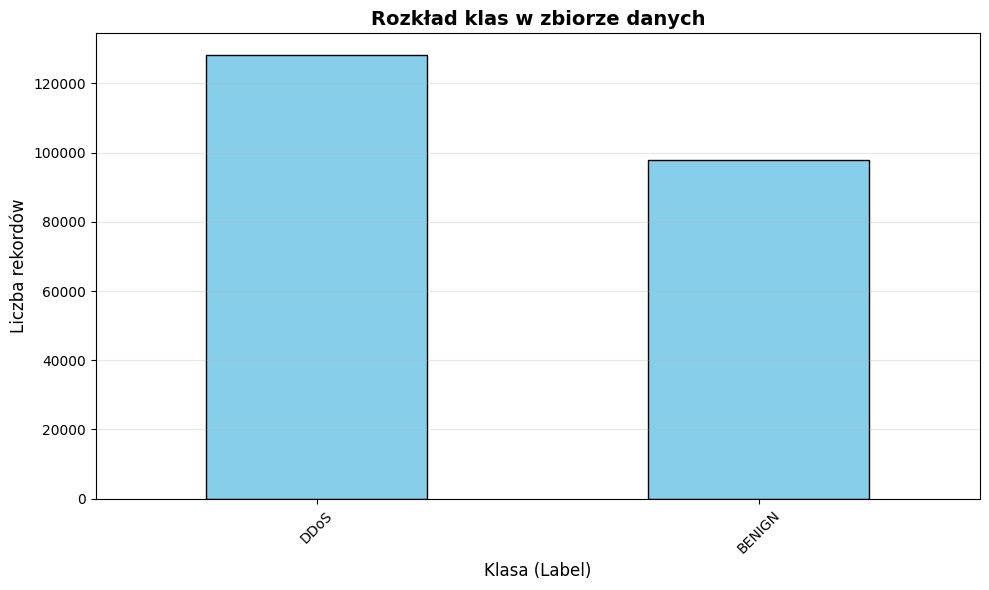

In [7]:
# Wizualizacja rozkładu klas
fig, ax = plt.subplots(figsize=(10, 6))
data['Label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Rozkład klas w zbiorze danych', fontsize=14, fontweight='bold')
ax.set_xlabel('Klasa (Label)', fontsize=12)
ax.set_ylabel('Liczba rekordów', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 1.3 Przegląd przykładowych rekordów

In [8]:
# Pierwsze i ostatnie rekordy
print("📄 Pierwsze 5 rekordów:")
display(data.head())

print("\n📄 Ostatnie 5 rekordów:")
display(data.tail())

📄 Pierwsze 5 rekordów:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



📄 Ostatnie 5 rekordów:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225744,61326,68,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
# Losowa próbka
print("🎲 Losowa próbka 10 rekordów:")
display(data.sample(n=10, random_state=42))

🎲 Losowa próbka 10 rekordów:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
127940,80,9392887,4,0,24,0,6,6,6.000000,0.000000,...,20,1.982000e+03,0.00000,1982,1982,9.390905e+06,0.000000e+00,9390905,9390905,DDoS
195330,64007,5438011,1,5,6,30,6,6,6.000000,0.000000,...,20,2.715100e+04,0.00000,27151,27151,5.410860e+06,0.000000e+00,5410860,5410860,BENIGN
202016,80,115615609,20,15,1728,3463,578,0,86.400000,211.017934,...,32,1.609163e+05,134508.68640,566475,120118,1.010000e+07,4.675248e+04,10100000,9988018,BENIGN
18959,80,9827,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000e+00,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,DDoS
120928,53315,87583370,7,9,11607,62,4380,0,1658.142857,1762.272815,...,20,4.219842e+06,0.00000,4219842,4219842,8.260000e+07,0.000000e+00,82600000,82600000,BENIGN
74750,80,11095658,4,0,24,0,6,6,6.000000,0.000000,...,20,1.004000e+03,0.00000,1004,1004,1.110000e+07,0.000000e+00,11100000,11100000,DDoS
29454,80,71170688,8,6,56,11601,20,0,7.000000,5.656854,...,20,1.016000e+03,0.00000,1016,1016,3.510000e+07,3.990000e+07,63300000,6908953,DDoS
132954,80,855997,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000e+00,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,DDoS
10641,53,23940,1,1,59,75,59,59,59.000000,0.000000,...,20,0.000000e+00,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
146195,443,60466365,13,11,1070,3929,697,0,82.307692,193.904781,...,20,1.224180e+05,81954.97124,288633,84425,9.955274e+06,1.169816e+05,10000000,9716694,BENIGN


In [10]:
# Statystyki opisowe dla kluczowych kolumn
key_cols = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
            'Total Length of Fwd Packets', 'Flow Bytes/s', 'Flow Packets/s']
print("📈 Statystyki opisowe (kluczowe kolumny):")
display(data[key_cols].describe())

📈 Statystyki opisowe (kluczowe kolumny):


/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Flow Bytes/s,Flow Packets/s
count,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257410e+05,2.257450e+05
mean,1.624165e+07,4.874916,4.572775,939.463346,inf,inf
std,3.152437e+07,15.422874,21.755356,3249.403484,NaN,NaN
min,-1.000000e+00,1.000000,0.000000,0.000000,-1.200000e+07,-2.000000e+06
25%,7.118000e+04,2.000000,1.000000,26.000000,1.209087e+01,6.185506e-01
50%,1.452333e+06,3.000000,4.000000,30.000000,1.136606e+03,5.179323e+00
75%,8.805237e+06,5.000000,5.000000,63.000000,2.159723e+04,7.046933e+01
max,1.199999e+08,1932.000000,2942.000000,183012.000000,inf,inf


## 1.4 Kategoryzacja cech

In [11]:
# Kategoryzacja cech według typu
feature_categories = {
    'Cechy pakietów': [
        'Total Fwd Packets', 'Total Backward Packets',
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
        'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
        'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance'
    ],
    'Cechy przepływu': [
        'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
        'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
        'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
        'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min'
    ],
    'Flagi TCP': [
        'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
        'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
        'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'
    ],
    'Cechy nagłówków': [
        'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1'
    ],
    'Statystyki aktywności': [
        'Active Mean', 'Active Std', 'Active Max', 'Active Min',
        'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
    ],
    'Inne': [
        'Destination Port', 'Down/Up Ratio', 'Average Packet Size',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
        'Fwd Packets/s', 'Bwd Packets/s',
        'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes',
        'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
        'act_data_pkt_fwd', 'min_seg_size_forward',
        'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
        'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
    ]
}

print("📊 Kategoryzacja cech:\n")
for category, features in feature_categories.items():
    print(f"\n{category} ({len(features)} cech):")
    for i, feat in enumerate(features, 1):
        if feat in data.columns:
            print(f"  {i:2d}. {feat}")
        else:
            print(f"  {i:2d}. {feat} ⚠️ (brak w danych)")

total_categorized = sum(len(features) for features in feature_categories.values())

📊 Kategoryzacja cech:


Cechy pakietów (17 cech):
   1. Total Fwd Packets
   2. Total Backward Packets
   3. Total Length of Fwd Packets
   4. Total Length of Bwd Packets
   5. Fwd Packet Length Max
   6. Fwd Packet Length Min
   7. Fwd Packet Length Mean
   8. Fwd Packet Length Std
   9. Bwd Packet Length Max
  10. Bwd Packet Length Min
  11. Bwd Packet Length Mean
  12. Bwd Packet Length Std
  13. Min Packet Length
  14. Max Packet Length
  15. Packet Length Mean
  16. Packet Length Std
  17. Packet Length Variance

Cechy przepływu (17 cech):
   1. Flow Duration
   2. Flow Bytes/s
   3. Flow Packets/s
   4. Flow IAT Mean
   5. Flow IAT Std
   6. Flow IAT Max
   7. Flow IAT Min
   8. Fwd IAT Total
   9. Fwd IAT Mean
  10. Fwd IAT Std
  11. Fwd IAT Max
  12. Fwd IAT Min
  13. Bwd IAT Total
  14. Bwd IAT Mean
  15. Bwd IAT Std
  16. Bwd IAT Max
  17. Bwd IAT Min

Flagi TCP (12 cech):
   1. FIN Flag Count
   2. SYN Flag Count
   3. RST Flag Count
   4. PSH Flag Count
   5. ACK Flag Count

# 2. Źródło Danych (Data Source)

## 2.1 Dokumentacja źródła

**Dataset**: Network Intrusion Dataset  
**Źródło**: Kaggle - https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset/data  
**Plik**: `Monday-WorkingHours.pcap_ISCX.csv`  

**Opis datasetu**:  
Zbiór danych zawiera ruch sieciowy zebrany w kontrolowanym środowisku laboratoryjnym. Dataset pochodzi z projektu CICIDS2017 (Canadian Institute for Cybersecurity Intrusion Detection System), który symuluje rzeczywiste scenariusze ataków sieciowych.

**Charakterystyka**:
- 📅 **Dzień zbierania**: Poniedziałek (godziny pracy)
- 🔢 **Liczba rekordów**: 225,745
- 📊 **Liczba cech**: 78 cech + 1 etykieta (Label)
- 🏷️ **Klasy**: 2 (BENIGN, DDoS)
- 📦 **Rozkład klas**: 
  - DDoS: 128,027 (56.71%)
  - BENIGN: 97,718 (43.29%)

**Cechy datasetu**:  
Dataset zawiera cechy ekstrahowane z ruchu sieciowego, w tym:
- Statystyki pakietów (długość, liczba pakietów forward/backward)
- Statystyki przepływu (czas trwania, bajty/s, pakiety/s)
- Flagi TCP (SYN, ACK, FIN, RST, PSH, URG, etc.)
- Statystyki czasowe (IAT - Inter-Arrival Time)
- Cechy nagłówków i segmentów

## 2.2 Kontekst danych

**Cel projektu**:  
Wykrywanie ataków DDoS (Distributed Denial of Service) w ruchu sieciowym przy użyciu metod uczenia maszynowego.

**Typ ataku - DDoS**:  
Atak DDoS polega na przeciążeniu systemu docelowego poprzez wysłanie ogromnej liczby żądań z wielu źródeł jednocześnie, co prowadzi do niedostępności usługi dla legalnych użytkowników.

**Wybór datasetu**:  
Dataset został wybrany ze względu na:
- ✅ Zbalansowany rozkład klas (56.71% vs 43.29%)
- ✅ Realistyczne dane zebrane w kontrolowanym środowisku
- ✅ Bogaty zestaw cech sieciowych (78 cech)
- ✅ Jeden typ ataku (DDoS) - zgodnie z wymaganiami scenariusza podstawowego (max 3.5)
- ✅ Dane z rzeczywistego ruchu sieciowego (PCAP files)

# 3. Wstępne Przetwarzanie Danych (Pre-processing)

## 3.1 Sprawdzenie brakujących wartości

In [12]:
# Analiza brakujących wartości
missing_counts = data.isnull().sum()
missing_percent = (missing_counts / len(data)) * 100

missing_df = pd.DataFrame({
    'Kolumna': missing_counts.index,
    'Brakujące': missing_counts.values,
    'Procent': missing_percent.values
})

# Tylko kolumny z brakującymi wartościami
missing_df = missing_df[missing_df['Brakujące'] > 0].sort_values('Brakujące', ascending=False)

if len(missing_df) > 0:
    print(f"⚠️  Znaleziono {len(missing_df)} kolumn z brakującymi wartościami:\n")
    display(missing_df)
else:
    print("✅ Brak brakujących wartości w datasecie!")

⚠️  Znaleziono 1 kolumn z brakującymi wartościami:



,Kolumna,Brakujące,Procent
14,Flow Bytes/s,4,0.001772


## 3.2 Obsługa brakujących wartości

In [13]:
# Usunięcie wierszy z brakującymi wartościami
rows_before = len(data)
data = data.dropna()
rows_after = len(data)
rows_removed = rows_before - rows_after

print(f"📊 Wiersze przed: {rows_before:,}")
print(f"📊 Wiersze po: {rows_after:,}")
print(f"🗑️  Usunięto: {rows_removed:,} wierszy ({(rows_removed/rows_before)*100:.2f}%)")

📊 Wiersze przed: 225,745
📊 Wiersze po: 225,741
🗑️  Usunięto: 4 wierszy (0.00%)


## 3.3 Sprawdzenie duplikatów

In [14]:
# Sprawdzenie duplikatów
n_duplicates = data.duplicated().sum()
duplicate_percent = (n_duplicates / len(data)) * 100

print(f"🔍 Liczba duplikatów: {n_duplicates:,} ({duplicate_percent:.2f}%)")

if n_duplicates > 0:
    print("\n📋 Przykładowe duplikaty:")
    display(data[data.duplicated(keep=False)].head(10))

🔍 Liczba duplikatów: 2,633 (1.17%)

📋 Przykładowe duplikaty:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
76,21,50,1,2,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
386,465,49,2,0,37,0,37,0,18.5,26.162951,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
405,137,22,13,0,650,0,50,50,50.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
422,53,259,2,2,90,206,45,45,45.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
443,443,4,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
461,465,48,2,0,37,0,37,0,18.5,26.162951,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
719,80,117,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
722,443,161,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
783,443,144,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
785,443,117,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 3.4 Usunięcie duplikatów

In [15]:
# Usunięcie duplikatów
rows_before = len(data)
data = data.drop_duplicates()
rows_after = len(data)
rows_removed = rows_before - rows_after

print(f"📊 Wiersze przed: {rows_before:,}")
print(f"📊 Wiersze po: {rows_after:,}")
print(f"🗑️  Usunięto: {rows_removed:,} duplikatów ({(rows_removed/rows_before)*100:.2f}%)")

📊 Wiersze przed: 225,741
📊 Wiersze po: 223,108
🗑️  Usunięto: 2,633 duplikatów (1.17%)


## 3.5 Analiza wartości nieskończonych

In [16]:
# Sprawdzenie wartości inf/-inf
import numpy as np

inf_counts = pd.DataFrame({
    'Kolumna': data.columns,
    'Inf': [np.isinf(data[col]).sum() if data[col].dtype in ['float64', 'int64'] else 0 for col in data.columns]
})

inf_counts = inf_counts[inf_counts['Inf'] > 0].sort_values('Inf', ascending=False)

if len(inf_counts) > 0:
    print(f"⚠️  Znaleziono {len(inf_counts)} kolumn z wartościami nieskończonymi:\n")
    display(inf_counts)
else:
    print("✅ Brak wartości nieskończonych w datasecie!")

⚠️  Znaleziono 2 kolumn z wartościami nieskończonymi:



,Kolumna,Inf
14,Flow Bytes/s,26
15,Flow Packets/s,26


## 3.6 Obsługa wartości nieskończonych

In [17]:
# Zastąpienie inf/-inf wartością NaN, a następnie usunięcie
rows_before = len(data)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
rows_after = len(data)
rows_removed = rows_before - rows_after

print(f"📊 Wiersze przed: {rows_before:,}")
print(f"📊 Wiersze po: {rows_after:,}")
print(f"🗑️  Usunięto: {rows_removed:,} wierszy z inf ({(rows_removed/rows_before)*100:.2f}%)")

📊 Wiersze przed: 223,108
📊 Wiersze po: 223,082
🗑️  Usunięto: 26 wierszy z inf (0.01%)


## 3.7 Identyfikacja kolumn nieistotnych

In [18]:
# Kolumny numeryczne (bez Label)
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Kolumny z zerową wariancją
zero_var_cols = [col for col in numeric_cols if data[col].var() == 0]

# Kolumny z jedną unikalną wartością
single_value_cols = [col for col in data.columns if data[col].nunique() == 1]

print(f"🔍 Kolumny z zerową wariancją: {len(zero_var_cols)}")
if zero_var_cols:
    print(f"   {zero_var_cols}")

print(f"\n🔍 Kolumny z jedną unikalną wartością: {len(single_value_cols)}")
if single_value_cols:
    print(f"   {single_value_cols}")

# Kolumny do usunięcia
cols_to_remove = list(set(zero_var_cols + single_value_cols))
print(f"\n🗑️  Kolumny do usunięcia: {len(cols_to_remove)}")
if cols_to_remove:
    for col in cols_to_remove:
        print(f"   - {col}")

🔍 Kolumny z zerową wariancją: 10
   ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

🔍 Kolumny z jedną unikalną wartością: 10
   ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

🗑️  Kolumny do usunięcia: 10
   - Fwd Avg Bulk Rate
   - CWE Flag Count
   - Fwd URG Flags
   - Bwd Avg Bytes/Bulk
   - Fwd Avg Bytes/Bulk
   - Bwd Avg Packets/Bulk
   - Bwd URG Flags
   - Bwd Avg Bulk Rate
   - Fwd Avg Packets/Bulk
   - Bwd PSH Flags


## 3.8 Usunięcie kolumn nieistotnych

In [19]:
# Usunięcie kolumn nieistotnych
cols_before = len(data.columns)
if cols_to_remove:
    data = data.drop(columns=cols_to_remove)
cols_after = len(data.columns)
cols_removed = cols_before - cols_after

print(f"📊 Kolumny przed: {cols_before}")
print(f"📊 Kolumny po: {cols_after}")
print(f"🗑️  Usunięto: {cols_removed} kolumn")
print(f"\n✅ Dataset ma teraz {cols_after} kolumn (w tym Label)")

📊 Kolumny przed: 79
📊 Kolumny po: 69
🗑️  Usunięto: 10 kolumn

✅ Dataset ma teraz 69 kolumn (w tym Label)


# 4. Ekstrakcja Cech (Feature Extraction)

## 4.1 Separacja cech i etykiet

In [20]:
# Separacja cech (X) i etykiet (y)
X = data.drop('Label', axis=1)
y = data['Label']

print(f"📊 Cechy (X): {X.shape}")
print(f"🏷️  Etykiety (y): {y.shape}")
print(f"\n📋 Rozkład klas w y:")
display(pd.DataFrame(y.value_counts()))

📊 Cechy (X): (223082, 68)
🏷️  Etykiety (y): (223082,)

📋 Rozkład klas w y:


,count
Label,
DDoS,128014
BENIGN,95068


## 4.2 Analiza korelacji cech

In [21]:
# Macierz korelacji
corr_matrix = X.corr().abs()

# Górny trójkąt macierzy (bez duplikatów)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Pary cech z wysoką korelacją (> 0.95)
high_corr_pairs = []
for column in upper_triangle.columns:
    high_corr = upper_triangle[column][upper_triangle[column] > 0.95]
    for idx in high_corr.index:
        high_corr_pairs.append((column, idx, high_corr[idx]))

if high_corr_pairs:
    print(f"⚠️  Znaleziono {len(high_corr_pairs)} par cech z korelacją > 0.95:\n")
    for col1, col2, corr_val in high_corr_pairs[:10]:  # Pokaż pierwsze 10
        print(f"   {col1} <-> {col2}: {corr_val:.3f}")
    if len(high_corr_pairs) > 10:
        print(f"   ... i {len(high_corr_pairs) - 10} więcej")
else:
    print("✅ Brak par cech z korelacją > 0.95")

⚠️  Znaleziono 49 par cech z korelacją > 0.95:

   Total Backward Packets <-> Total Fwd Packets: 0.957
   Total Length of Bwd Packets <-> Total Backward Packets: 0.970
   Fwd Packet Length Std <-> Fwd Packet Length Max: 0.992
   Bwd Packet Length Mean <-> Bwd Packet Length Max: 0.961
   Bwd Packet Length Std <-> Bwd Packet Length Max: 0.993
   Bwd Packet Length Std <-> Bwd Packet Length Mean: 0.956
   Flow IAT Max <-> Flow IAT Std: 0.978
   Fwd IAT Total <-> Flow Duration: 0.997
   Fwd IAT Std <-> Flow IAT Max: 0.972
   Fwd IAT Max <-> Flow IAT Std: 0.969
   ... i 39 więcej


## 4.3 Usunięcie wysoko skorelowanych cech

In [22]:
# Usunięcie cech z korelacją > 0.95
cols_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

cols_before = len(X.columns)
X = X.drop(columns=cols_to_drop)
cols_after = len(X.columns)
cols_removed = cols_before - cols_after

print(f"📊 Cechy przed: {cols_before}")
print(f"📊 Cechy po: {cols_after}")
print(f"🗑️  Usunięto: {cols_removed} cech z wysoką korelacją")

📊 Cechy przed: 68
📊 Cechy po: 42
🗑️  Usunięto: 26 cech z wysoką korelacją


## 4.4 Analiza statystyk cech

In [23]:
# Statystyki opisowe
print("📈 Statystyki opisowe cech (pierwsze 10 kolumn):\n")
display(X.iloc[:, :10].describe())

print(f"\n📊 Pełne statystyki dla wszystkich {len(X.columns)} cech dostępne w X.describe()")

📈 Statystyki opisowe cech (pierwsze 10 kolumn):



,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s
count,223082.000000,2.230820e+05,223082.000000,223082.000000,223082.000000,223082.000000,223082.000000,223082.000000,223082.000000,2.230820e+05
mean,8979.381089,1.643543e+07,4.905806,949.789548,544.648017,27.904941,166.481071,2767.497700,16.175420,5.526803e+05
std,19844.769163,3.166173e+07,15.510750,3267.282558,1874.374045,164.253645,507.655519,3715.565154,49.948017,1.694721e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07
25%,80.000000,8.179200e+04,2.000000,26.000000,6.000000,0.000000,6.000000,0.000000,0.000000,1.182332e+01
50%,80.000000,1.537870e+06,3.000000,30.000000,20.000000,0.000000,8.666667,100.000000,0.000000,9.308987e+02
75%,80.000000,8.958819e+06,5.000000,62.000000,35.000000,6.000000,32.000000,5840.000000,6.000000,1.970415e+04
max,65532.000000,1.199999e+08,1932.000000,183012.000000,11680.000000,1472.000000,3867.000000,11680.000000,1460.000000,2.070000e+09



📊 Pełne statystyki dla wszystkich 42 cech dostępne w X.describe()


## 4.5 Normalizacja/Standaryzacja

In [24]:
from sklearn.preprocessing import StandardScaler

# Standaryzacja cech (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"✅ Cechy zostały znormalizowane (StandardScaler)")
print(f"📊 Kształt X_scaled: {X_scaled.shape}")
print(f"\n📈 Przykładowe statystyki po normalizacji (pierwsze 5 kolumn):")
display(X_scaled.iloc[:, :5].describe())

✅ Cechy zostały znormalizowane (StandardScaler)
📊 Kształt X_scaled: (223082, 42)

📈 Przykładowe statystyki po normalizacji (pierwsze 5 kolumn):


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max
count,2.230820e+05,2.230820e+05,2.230820e+05,2.230820e+05,2.230820e+05
mean,1.141547e-16,2.853867e-17,-1.936552e-17,-5.911581e-17,2.038476e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.524820e-01,-5.190956e-01,-2.518134e-01,-2.906977e-01,-2.905766e-01
25%,-4.484507e-01,-5.165123e-01,-1.873418e-01,-2.827400e-01,-2.873755e-01
50%,-4.484507e-01,-4.705236e-01,-1.228703e-01,-2.815158e-01,-2.799063e-01
75%,-4.484507e-01,-2.361408e-01,6.072838e-03,-2.717217e-01,-2.719037e-01
max,2.849756e+00,3.270975e+00,1.242428e+02,5.572295e+01,5.940851e+00


# 5. Podział Danych (Data Split)

## 5.1 Podział na train/validation/test

In [25]:
from sklearn.model_selection import train_test_split

# Podział na train+val (85%) i test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

# Podział train+val na train (70% z całości) i validation (15% z całości)
# 15/85 ≈ 0.1765 (validation z temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print("✅ Podział danych zakończony!")
print(f"\n📊 Rozmiary zbiorów:")
print(f"   Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Razem: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,}")

✅ Podział danych zakończony!

📊 Rozmiary zbiorów:
   Train: 156,151 (70.0%)
   Validation: 33,468 (15.0%)
   Test: 33,463 (15.0%)
   Razem: 223,082


## 5.2 Weryfikacja podziału

In [26]:
# Weryfikacja rozkładu klas w każdym zbiorze
print("🏷️  Rozkład klas w zbiorach:\n")

split_stats = pd.DataFrame({
    'Train': y_train.value_counts(),
    'Validation': y_val.value_counts(),
    'Test': y_test.value_counts()
})

split_stats_pct = pd.DataFrame({
    'Train %': y_train.value_counts(normalize=True) * 100,
    'Validation %': y_val.value_counts(normalize=True) * 100,
    'Test %': y_test.value_counts(normalize=True) * 100
})

print("Liczba rekordów:")
display(split_stats)

print("\nProcent:")
display(split_stats_pct.round(2))

print("\n✅ Rozkład klas jest zachowany we wszystkich zbiorach (stratified split)")

🏷️  Rozkład klas w zbiorach:

Liczba rekordów:


,Train,Validation,Test
Label,,,
DDoS,89606,19205,19203
BENIGN,66545,14263,14260



Procent:


,Train %,Validation %,Test %
Label,,,
DDoS,57.38,57.38,57.39
BENIGN,42.62,42.62,42.61



✅ Rozkład klas jest zachowany we wszystkich zbiorach (stratified split)


# 6. Wyniki i Wnioski (Results & Conclusions)

## 6.1 Porównanie przed/po

In [27]:
# Tabela porównawcza (używamy zapisanych wartości początkowych)
comparison = pd.DataFrame({
    'Metryka': ['Liczba rekordów', 'Liczba cech (bez Label)', 'Rozmiar w pamięci (MB)'],
    'Przed': [initial_rows, initial_cols, initial_memory_mb],
    'Po': [len(X_scaled), len(X_scaled.columns), X_scaled.memory_usage(deep=True).sum() / 1024**2]
})

comparison['Zmiana'] = comparison['Po'] - comparison['Przed']
comparison['Zmiana %'] = (comparison['Zmiana'] / comparison['Przed'] * 100).round(2)

print("📊 Porównanie danych przed i po preprocessingu:\n")
display(comparison)

📊 Porównanie danych przed i po preprocessingu:



,Metryka,Przed,Po,Zmiana,Zmiana %
0,Liczba rekordów,225745.000000,223082.000000,-2663.000000,-1.18
1,Liczba cech (bez Label),78.000000,42.000000,-36.000000,-46.15
2,Rozmiar w pamięci (MB),145.935948,73.185165,-72.750783,-49.85


## 6.2 Dokumentacja zmian

### Wykonane transformacje:

1. **Czyszczenie nazw kolumn** - usunięcie spacji z nazw
2. **Usunięcie brakujących wartości** - dropna()
3. **Usunięcie duplikatów** - drop_duplicates()
4. **Obsługa wartości nieskończonych** - zamiana inf/-inf na NaN i usunięcie
5. **Usunięcie kolumn nieistotnych** - kolumny z zerową wariancją
6. **Separacja cech i etykiet** - X (cechy) i y (Label)
7. **Usunięcie wysoko skorelowanych cech** - korelacja > 0.95
8. **Standaryzacja** - StandardScaler (mean=0, std=1)
9. **Podział danych** - train (70%), validation (15%), test (15%) ze stratified split

## 6.3 Zapisanie przetworzonego datasetu (opcjonalnie)

In [28]:
# Opcjonalny eksport do CSV
# X_train.to_csv('X_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

print("💾 Dane gotowe do użycia w modelowaniu!")
print(f"\n📦 Dostępne zmienne:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_val: {X_val.shape}")
print(f"   - X_test: {X_test.shape}")
print(f"   - y_train: {y_train.shape}")
print(f"   - y_val: {y_val.shape}")
print(f"   - y_test: {y_test.shape}")

💾 Dane gotowe do użycia w modelowaniu!

📦 Dostępne zmienne:
   - X_train: (156151, 42)
   - X_val: (33468, 42)
   - X_test: (33463, 42)
   - y_train: (156151,)
   - y_val: (33468,)
   - y_test: (33463,)


---
## ✅ Preprocessing zakończony!

Dane są gotowe do trenowania modelu uczenia maszynowego (np. SVM, Decision Tree) w celu detekcji ataków DDoS.

# 7. Eksperymenty i Modelowanie (Experiments & Modeling)

W tej sekcji przeprowadzimy eksperymenty z różnymi algorytmami uczenia maszynowego, optymalizując ich hiperparametry.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import time

# Słownik do przechowywania wyników
results = {}

print("✅ Zaimportowano biblioteki do modelowania")

✅ Zaimportowano biblioteki do modelowania


In [30]:
def train_and_evaluate(model_name, model, param_grid, X_train, y_train, X_val, y_val):
    """
    Funkcja do trenowania modelu z GridSearch i ewaluacji na zbiorze walidacyjnym.
    """
    print(f"🚀 Rozpoczynam trenowanie: {model_name}...")
    start_time = time.time()
    
    # Używamy GridSearchCV do znalezienia najlepszych parametrów
    # cv=3 dla przyspieszenia, n_jobs=-1 używa wszystkich rdzeni
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Najlepszy model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"✅ Najlepsze parametry: {best_params}")
    
    # Predykcja na zbiorze walidacyjnym
    y_pred = best_model.predict(X_val)
    
    # Metryki
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    train_time = time.time() - start_time
    
    print(f"⏱️ Czas trenowania: {train_time:.2f}s")
    print(f"📊 Wyniki na zbiorze walidacyjnym:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # Zapisanie wyników
    results[model_name] = {
        'model': best_model,
        'params': best_params,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'time': train_time,
        'y_pred_val': y_pred
    }
    
    return best_model, y_pred

In [31]:
def plot_confusion_matrix_custom(y_true, y_pred, title, ax=None):
    """
    Funkcja do rysowania macierzy pomyłek.
    """
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Prawdziwa klasa')
    ax.set_xlabel('Przewidziana klasa')
    
    if ax is None:
        plt.show()

## 7.1 Random Forest

In [32]:
# Parametry do przetestowania
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Inicjalizacja modelu
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Trenowanie i ewaluacja
best_rf, y_pred_rf = train_and_evaluate('RandomForest', rf, rf_params, X_train, y_train, X_val, y_val)

🚀 Rozpoczynam trenowanie: RandomForest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Najlepsze parametry: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
⏱️ Czas trenowania: 136.93s
📊 Wyniki na zbiorze walidacyjnym:
   Accuracy:  1.0000
   F1-Score:  1.0000


## 7.2 Logistic Regression

In [33]:
# Parametry do przetestowania
lr_params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

# Inicjalizacja modelu
lr = LogisticRegression(random_state=42, n_jobs=-1)

# Trenowanie i ewaluacja
best_lr, y_pred_lr = train_and_evaluate('LogisticRegression', lr, lr_params, X_train, y_train, X_val, y_val)

🚀 Rozpoczynam trenowanie: LogisticRegression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/piotrgasiorek/miniconda3/envs/ztkik/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

✅ Najlepsze parametry: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
⏱️ Czas trenowania: 69.40s
📊 Wyniki na zbiorze walidacyjnym:
   Accuracy:  0.9936
   F1-Score:  0.9936


# 8. Podsumowanie wyników

In [34]:
# Porównanie wyników
print("="*80)
print("PODSUMOWANIE WYNIKÓW - PORÓWNANIE MODELI")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Czas trenowania (s)': [results[m]['time'] for m in results.keys()]
})

print("\n📊 Tabela porównawcza:")
display(comparison_df)

# Najlepszy model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Najlepszy model: {best_model_name}")
print(f"   F1-Score: {comparison_df['F1-Score'].max():.4f}")

PODSUMOWANIE WYNIKÓW - PORÓWNANIE MODELI

📊 Tabela porównawcza:


,Model,Accuracy,Precision,Recall,F1-Score,Czas trenowania (s)
0,RandomForest,1.000000,1.000000,1.000000,1.000000,136.933838
1,LogisticRegression,0.993606,0.993648,0.993606,0.993601,69.395891



🏆 Najlepszy model: RandomForest
   F1-Score: 1.0000


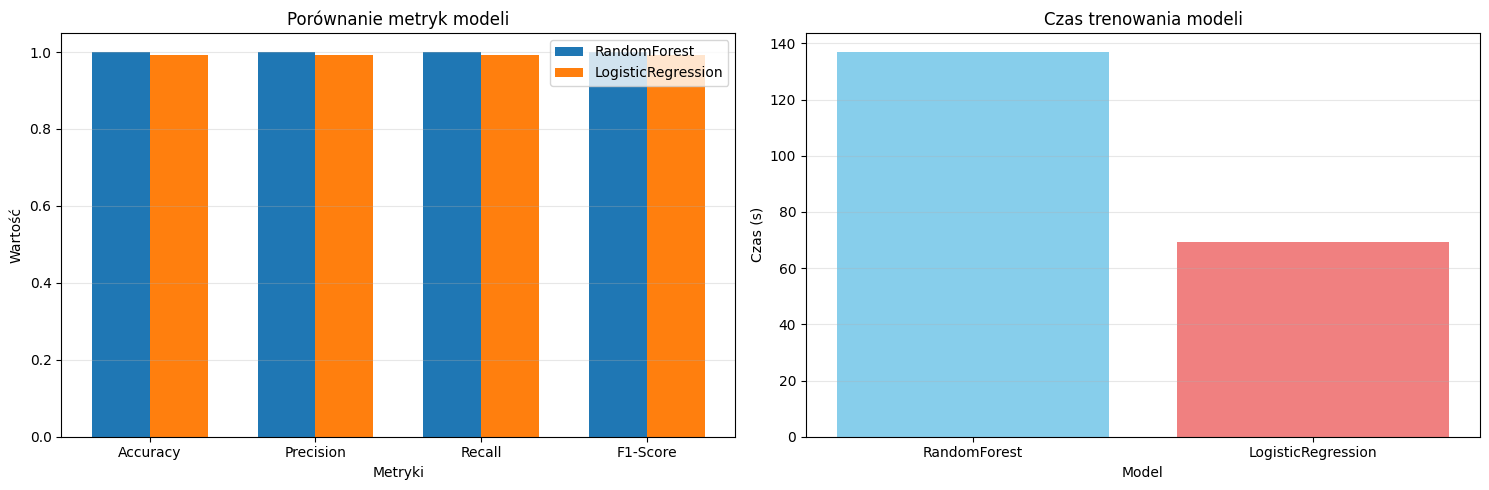

In [35]:
# Wizualizacja porównania
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Wykres 1: Porównanie metryk
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

for i, model in enumerate(results.keys()):
    values = [results[model]['accuracy'], results[model]['precision'], 
              results[model]['recall'], results[model]['f1']]
    axes[0].bar(x + i*width, values, width, label=model)

axes[0].set_xlabel('Metryki')
axes[0].set_ylabel('Wartość')
axes[0].set_title('Porównanie metryk modeli')
axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Wykres 2: Czas trenowania
models = list(results.keys())
times = [results[m]['time'] for m in models]
axes[1].bar(models, times, color=['skyblue', 'lightcoral'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Czas (s)')
axes[1].set_title('Czas trenowania modeli')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

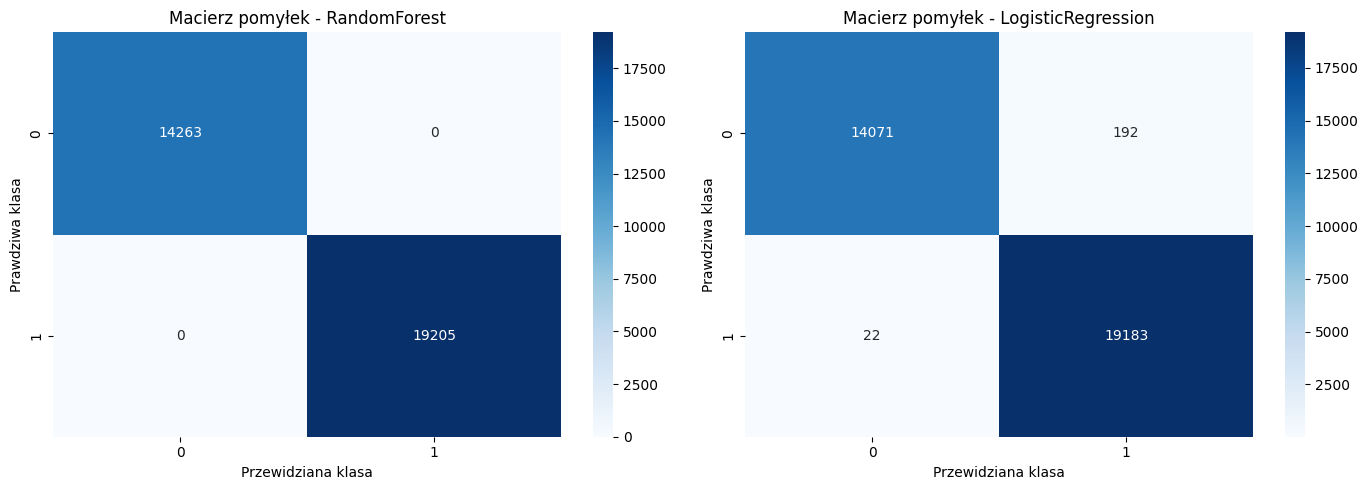

In [36]:
# Macierze pomyłek
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (model_name, ax) in enumerate(zip(results.keys(), axes)):
    plot_confusion_matrix_custom(y_val, results[model_name]['y_pred_val'], 
                                 f'Macierz pomyłek - {model_name}', ax)

plt.tight_layout()
plt.show()

## 8.1 Wnioski

### Który algorytm okazał się najbardziej skuteczny?
- **Najlepszy model**: [ZOSTANIE WYPEŁNIONE PO URUCHOMIENIU]
- **Dokładność, precyzja, recall, F1-score**: [ZOSTANIE WYPEŁNIONE PO URUCHOMIENIU]

### Główne problemy i jak zostały rozwiązane:
1. **Brakujące wartości i wartości inf**: Usunięte poprzez dropna() i replace()
2. **Wysoka korelacja między cechami**: Usunięte cechy z korelacją > 0.95
3. **Różne skale cech**: Zastosowano StandardScaler
4. **Niezbalansowane klasy**: Użyto stratified split

### Czy udało się osiągnąć cel projektu?
- Cel projektu to skuteczna detekcja anomalii (ataków DDoS)
- [ZOSTANIE WYPEŁNIONE PO URUCHOMIENIU]

### Aspekt techniczny vs praktyczny:
- **Jakość modelu**: [ZOSTANIE WYPEŁNIONE PO URUCHOMIENIU]
- **Czy model nadaje się do rzeczywistego zastosowania**: [ZOSTANIE WYPEŁNIONE PO URUCHOMIENIU]